In [270]:
import pandas as pd
import pyarrow.parquet as pq
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sbs
import numpy as np

# Introduction

We aim to extract meaningful data from the GDELT 2.0 dataset. 

We want to analyse the media coverage of violent events in some specific countries (Afghanistan, Syria, Iraq, Pakistan and Mexico) over the years 2000 to 2016.

We used :

* *ActionGeo_CountryName*, the 2-character FIPS10-4 country code for the location of the events to get the countries.
* [*EventRootCode*](http://data.gdeltproject.org/documentation/CAMEO.Manual.1.1b3.pdf) 18, 19 and 20 that correspond to the most violent events in the documentation.
* *MonthYear* to have the date (in month and year) of each event
* *Events* that we got from our SQL query as being the number of events per month
* *Articles* from our SQL query as well, being the number of Articles per month

We chose to extract data from the [**UCDP**](http://ucdp.uu.se/) dataset, we kept only our featured countries and the best estimation given for the number of deaths per year.

## Processing of the UCDP dataset

In [271]:
articles_year = pd.read_csv('totart_code181920.csv')#('Tot_articles_per_year.csv')
articles_year = articles_year[(articles_year['Year'] >= 2000) & (articles_year['Year'] <= 2016)]

events_year = pd.read_csv('totevent_code181920.csv')#('Total_Events_per_Year.csv')
events_year = events_year[(events_year['Year'] >= 2000) & (events_year['Year'] <= 2016)]

events_year.head()

,Year,NumEvents
21,2000,330047
22,2001,390659
23,2002,344684
24,2003,403647
25,2004,401826


In [272]:
# Getting deaths datasets (UCDP)

deaths = pd.read_csv('ged171.csv')
deaths = deaths[(deaths['year'] >= 2000) & (deaths['year'] <= 2016)]
deaths = deaths[['year', 'country', 'best']]
deaths.columns = ['Date', 'Country', 'Deaths']

Create one dataframe per country:

In [273]:
def deaths_country(_df, country_name):
    x = _df[_df['Country'] == country_name].drop('Country', axis=1).groupby('Date').sum().reset_index()
    if(country_name == 'Mexico'):
        # We need to artificially add some rows for mexico due to missing (no deaths) data these years
        x = x.append(pd.DataFrame([[2003, 0], [2000, 0], [2001, 0]], columns=['Date', 'Deaths'])).sort_values('Date')
    x['Deaths'] = x['Deaths']
    return x.set_index('Date')

In [274]:
deaths_irq = deaths_country(deaths, 'Iraq')
deaths_afg = deaths_country(deaths, 'Afghanistan')
deaths_mex = deaths_country(deaths, 'Mexico')
deaths_pak = deaths_country(deaths, 'Pakistan')

deaths_irq.head()

,Deaths
Date,
2000,185
2001,27
2002,111
2003,7999
2004,4365


## Processing of our aggregation of the GDELT dataset

We first tried to get the data from the cluseter but the dataset present on it was a subset of GDELT. Therefore most of the features were missing. To get the location of an event we used at first "Source" and "Target" field that matched the country we were intrested in. But those entries were not consistent.
The full dataset was supposed to have an ActionGeo_Country code which represent the county were the event took place. We were also supposed to have access to features like "MonthYear", "EventRootCode",...

For all those reasons we decided to stop using the cluster and make our query on the full GDELT dataset using the [Google Big Query](https://bigquery.cloud.google.com/table/gdelt-bq:gdeltv2.events)

The sql queries can be found on the repository

In [275]:
# Getting the aggregate dataset from our GDELT query (2000-2016)

df = pd.read_csv('big_query_2000_2016.csv')
df.columns = ['Country', 'Date', 'EventCode', 'Events', 'Articles']

tmp = pd.DataFrame(df['Date'].apply(lambda x: int(x / 100))).rename(columns={'Date': 'Year'})
tmp[['Articles', 'Events']] = df[['Articles', 'Events']]
tmp = tmp.merge(articles_year).merge(events_year)
tmp['Articles'] = (tmp['Articles'] / tmp['NumArticles'])
tmp['Events'] = (tmp['Events'] / tmp['NumEvents'])

df[['Articles', 'Events']] = tmp[['Articles', 'Events']]

tmp.drop(['NumEvents', 'NumArticles', 'Year'], axis=1)

,Articles,Events
0,5.236505e-03,0.004158
1,4.821809e-03,0.003789
2,4.537839e-03,0.004389
3,4.397721e-03,0.003578
4,4.289281e-03,0.003825
5,4.117429e-03,0.002609
6,3.901486e-03,0.003086
7,3.823644e-03,0.002495
8,3.594583e-03,0.002369
9,3.459495e-03,0.003180


The data that we get out of our query is the number of Event and the number of Articles aggregated per country, MonthYear and EventCode.
Aggregating the data this way enables us to work on a consise dataset(compared to the original enormous GDELT). However we still keep the different event code and month data separated for further analysis.

In [276]:
df.head()

,Country,Date,EventCode,Events,Articles
0,SY,201609,19,0.004158,0.005237
1,SY,201608,19,0.003789,0.004822
2,SY,201602,19,0.004389,0.004538
3,SY,201510,19,0.003578,0.004398
4,SY,201612,19,0.003825,0.004289


In [277]:
def df_country(_df, country):
    return _df[_df.Country == country].drop('Country', axis=1).set_index(['Date'])

DataFrame with merged event code:

In [278]:
df_grouped = df.groupby(['Date', 'Country']).sum().drop(['EventCode'], axis=1).sort_index(level=[0,1])

df_merged = df_grouped.reset_index()

irq = df_country(df_merged, 'IZ')
mex = df_country(df_merged, 'MX')
pak = df_country(df_merged, 'PK')
afg = df_country(df_merged, 'AF')
syr = df_country(df_merged, 'SY')

df_merged.head()

,Date,Country,Events,Articles
0,200001,AF,0.002455,0.002453
1,200001,IZ,0.000407,0.000301
2,200001,MX,0.004393,0.005433
3,200001,PK,0.002239,0.002177
4,200001,SY,0.000305,0.000275


## Separation by country and aggregation per year

In [279]:
# Here we process the dataset to only reason by year and normalize the Articles and Events by year. We then
# get the Ratio Articles/Events

df_year = df_merged.copy()

df_year['Date'] = df_year['Date'].apply(lambda d: int(d/100))

df_year = df_year.groupby(['Date', 'Country']).sum()
df_year = (df_year / df_year.std()).reset_index()

df_year['Ratio'] = df_year['Articles'] / df_year['Events'].astype('float')

#df_year.drop(['Articles', 'Events'], axis=1, inplace=True)

irq_year1 = df_country(df_year, 'IZ')
mex_year1 = df_country(df_year, 'MX')
pak_year1 = df_country(df_year, 'PK')
afg_year1 = df_country(df_year, 'AF')
syr_year1 = df_country(df_year, 'SY')

df_year.head()

,Date,Country,Events,Articles,Ratio
0,2000,AF,4.242186,3.764931,0.887498
1,2000,IZ,3.159566,2.827667,0.894954
2,2000,MX,5.154469,4.508636,0.874704
3,2000,PK,4.749720,4.614945,0.971625
4,2000,SY,2.030646,1.616556,0.796080


## Some plots and describes

## Normalization

We chose to normalize the ratio during the aggregation by year and normalize the deaths with a mean/std normalization. It seems to give reasonablre results for now but we might do a more refined normalization in the future.

In [280]:
def normalize(_df):
    x = _df.copy()
    #d = x['Deaths']
    #x['Deaths'] = abs(d - d.mean()) / d.std()
    #x = abs(x - x.min()) / (x.max() - x.min())
    return x

irq_year = deaths_irq.join(irq_year1)
mex_year = deaths_mex.join(mex_year1)
pak_year = deaths_pak.join(pak_year1)
afg_year = deaths_afg.join(afg_year1)

irq_year_normalized = normalize(irq_year)
mex_year_normalized = normalize(mex_year)
pak_year_normalized = normalize(pak_year)
afg_year_normalized = normalize(afg_year)

irq_year_normalized

,Deaths,Events,Articles,Ratio
Date,,,,
2000,185,3.159566,2.827667,0.894954
2001,27,2.716475,2.373155,0.873615
2002,111,2.519822,2.051480,0.814137
2003,7999,3.116896,2.731123,0.876232
2004,4365,3.156413,2.964102,0.939073
2005,3521,4.152762,4.435722,1.068138
2006,4609,2.947239,2.473825,0.839370
2007,4489,4.328332,4.179108,0.965524
2008,2732,3.112853,2.881639,0.925723


## Some exploration of the data through description and plots

In [281]:
irq_year.describe()

,Deaths,Events,Articles,Ratio
count,17.000000,17.000000,17.000000,17.000000
mean,4459.294118,3.510611,3.290647,0.931359
std,4390.300499,0.759707,0.838999,0.065194
min,27.000000,2.519822,2.051480,0.814137
25%,1407.000000,2.992851,2.731123,0.887269
50%,3521.000000,3.159566,2.964102,0.934624
75%,4609.000000,4.152762,3.983813,0.965524
max,15010.000000,5.115785,4.944996,1.068138


In [282]:
mex_year.describe()

,Deaths,Events,Articles,Ratio
count,17.000000,17.000000,17.000000,17.000000
mean,1115.764706,3.293395,3.102410,0.929565
std,1041.491450,1.255188,1.299699,0.088687
min,0.000000,1.543282,1.156241,0.693171
25%,187.000000,2.561258,2.286448,0.874704
50%,776.000000,2.906426,2.898550,0.943558
75%,1699.000000,3.873716,3.821229,0.990383
max,3313.000000,6.125149,6.263692,1.046640


In [283]:
pak_year.describe()

,Deaths,Events,Articles,Ratio
count,17.000000,17.000000,17.000000,17.000000
mean,2290.882353,3.133597,2.920294,0.935425
std,2437.833974,0.931921,0.858562,0.060050
min,1.000000,1.900609,1.850691,0.855652
25%,241.000000,2.588347,2.239257,0.892569
50%,1366.000000,2.827711,2.513238,0.930562
75%,3540.000000,3.894146,3.522774,0.960478
max,7460.000000,4.749720,4.614945,1.089553


In [284]:
afg_year.describe()

,Deaths,Events,Articles,Ratio
count,17.000000,17.000000,17.000000,17.000000
mean,7038.176471,2.971707,2.661773,0.895807
std,5235.884622,0.855483,0.802716,0.071448
min,817.000000,1.963615,1.514238,0.771148
25%,4982.000000,2.431927,2.166448,0.855352
50%,6499.000000,2.793658,2.471398,0.887498
75%,7822.000000,3.324882,2.993471,0.937075
max,18707.000000,4.875105,4.743734,1.050429


In [285]:
# Plot a barplot of the number od death per year, over the ratio number of article per event per year.
def plot_tendency(country_name,deaths, ratio):
    #global parameters
    fig_height = 12
    fig_weight = 12
    date = np.arange(2000,2017,1,dtype=np.int64) # stop value excluded
    year_xlabel = r"year of study"
    left_axis = r"ratio article/event"
    right_axis = r"number of deaths"    
    
    tendency_title = r"Media Coverage Tendency Over The Number Of Death in "+country_name
    f,ax_ = plt.subplots(sharex=True)
    f.set_figheight(fig_height)
    f.set_figwidth(fig_weight)
    plt.title(tendency_title)
    plt.xlabel(year_xlabel)
    
    ax_.set_xticks(date)
    ax_right = ax_.twinx()

    ax_.bar(date,deaths)
    ax_right.plot(date,ratio,color='r' )

    plt.show()

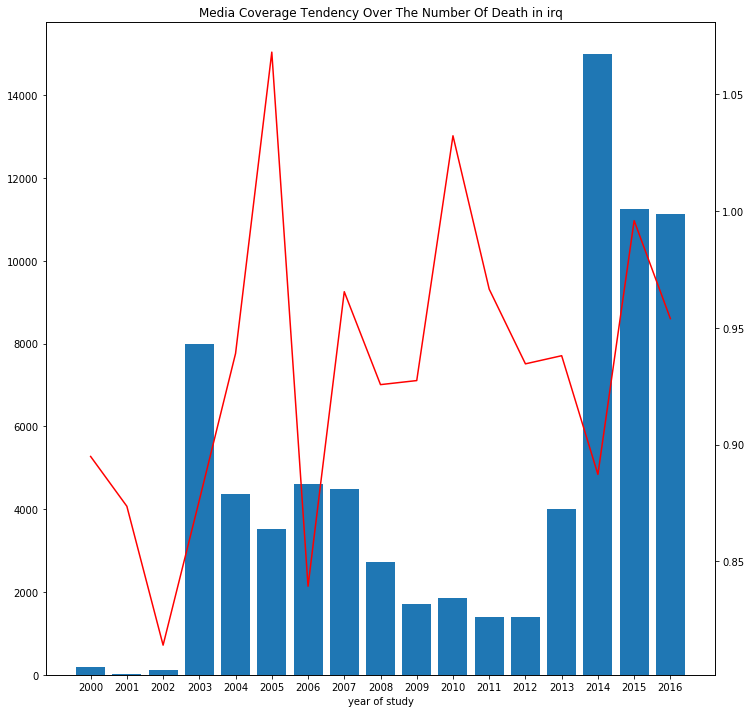

In [286]:
plot_tendency('irq', irq_year_normalized['Deaths'], irq_year_normalized['Ratio'])

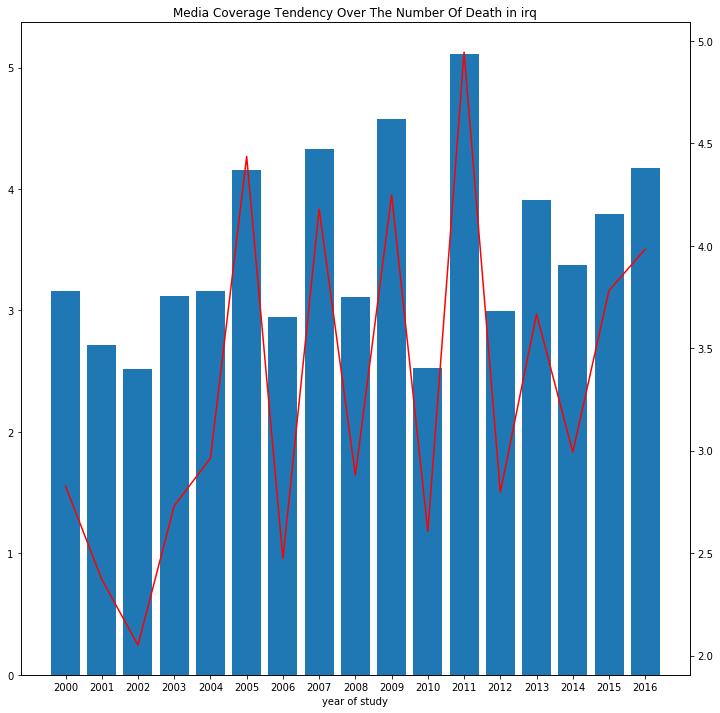

In [306]:
plot_tendency('irq', irq_year_normalized['Events'], irq_year_normalized['Articles'])

* 2003 : Beginning of war
* 2006 : ???
* 2009 : Obama
* 2009 - 2014 : loss of interest
* 2014 - 2016 : quite correlated

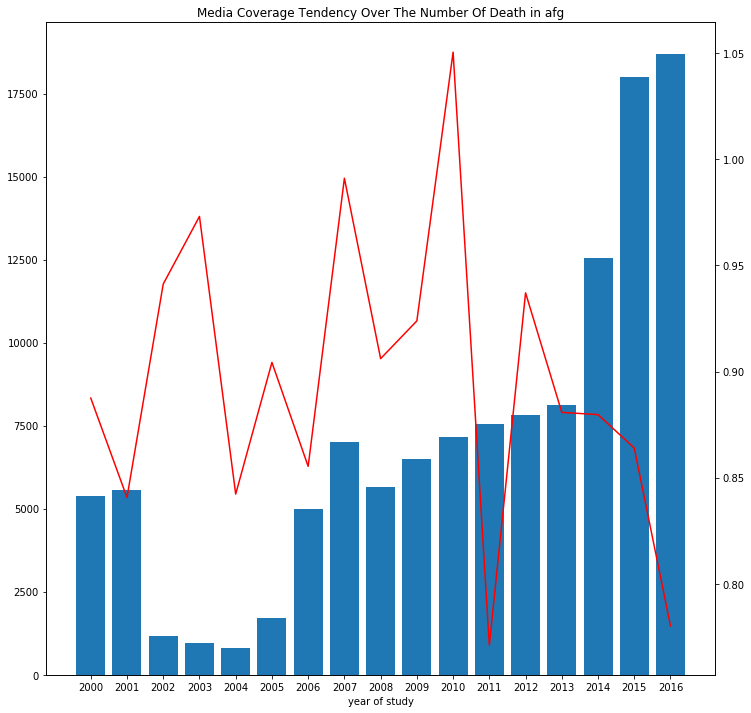

In [287]:
plot_tendency('afg', afg_year_normalized['Deaths'], afg_year_normalized['Ratio'])

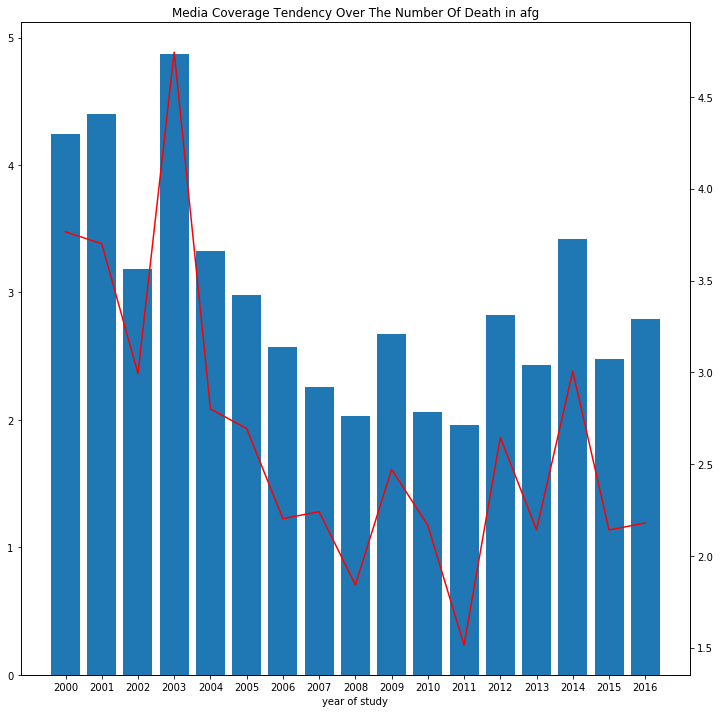

In [307]:
plot_tendency('afg', afg_year_normalized['Events'], afg_year_normalized['Articles'])

* 2002 : Arab spring ?
* 2009 : Obama
* 2010 loos of interest
* 2015-16 : clear loss of interest

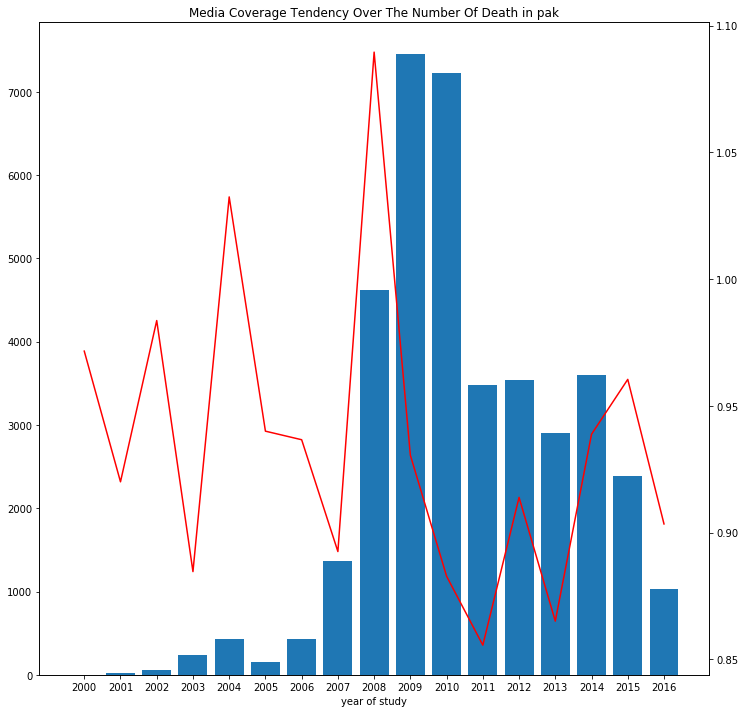

In [288]:
plot_tendency('pak', pak_year_normalized['Deaths'], pak_year_normalized['Ratio'])

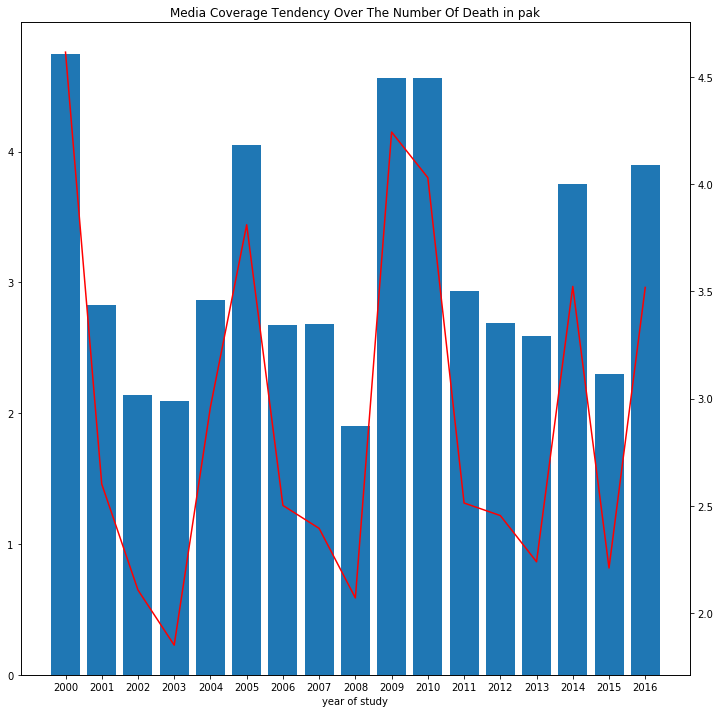

In [308]:
plot_tendency('pak', pak_year_normalized['Events'], pak_year_normalized['Articles'])

* 2004 : terrorist act
* 2009 : loss of interest ?

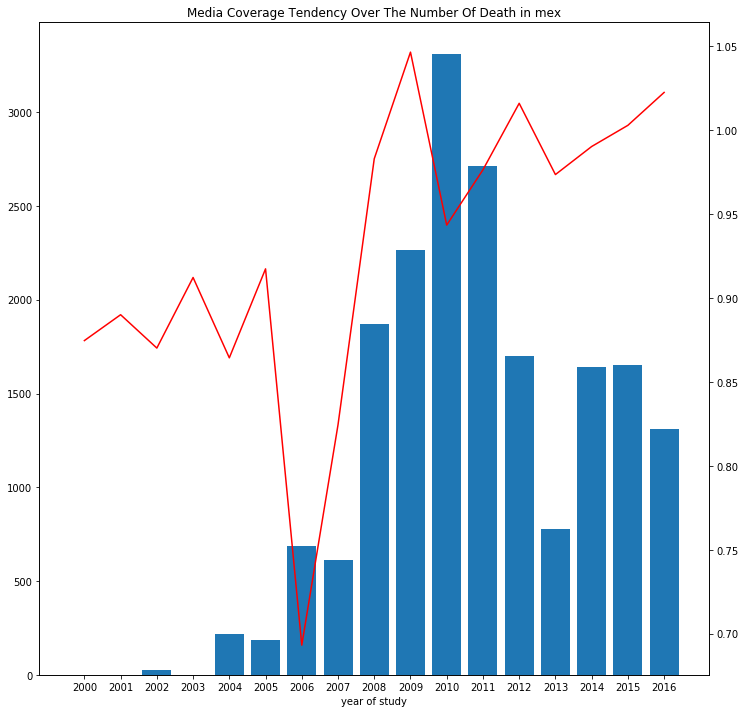

In [289]:
plot_tendency('mex', mex_year_normalized['Deaths'], mex_year_normalized['Ratio'])

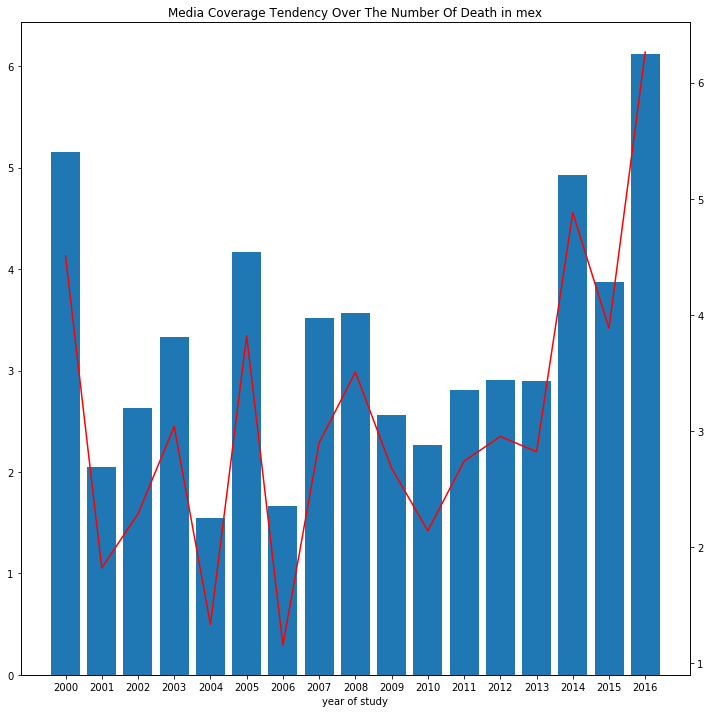

In [309]:
plot_tendency('mex', mex_year_normalized['Events'], mex_year_normalized['Articles'])

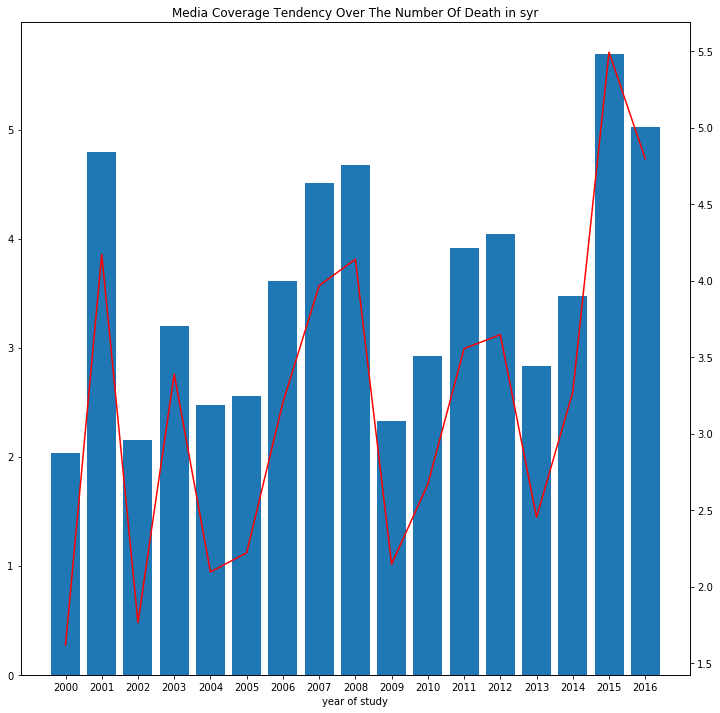

In [310]:
plot_tendency('syr', syr_year1['Events'], syr_year1['Articles'])

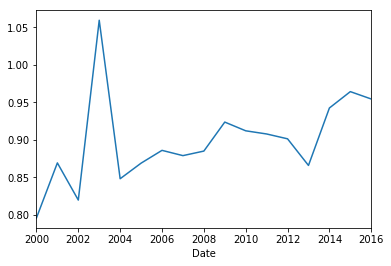

In [313]:
syr_year1['Ratio'].plot()

In [291]:
afg_year.corr()

,Deaths,Events,Articles,Ratio
Deaths,1.000000,-0.325845,-0.409062,-0.354277
Events,-0.325845,1.000000,0.970167,-0.005261
Articles,-0.409062,0.970167,1.000000,0.225995
Ratio,-0.354277,-0.005261,0.225995,1.000000


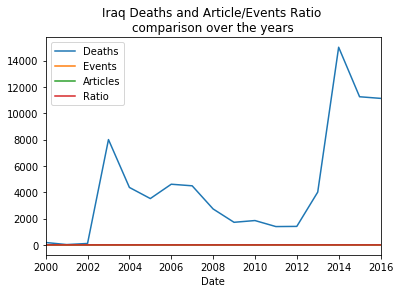

In [292]:
irq_year_normalized.plot(kind='line', title='Iraq Deaths and Article/Events Ratio \ncomparison over the years');

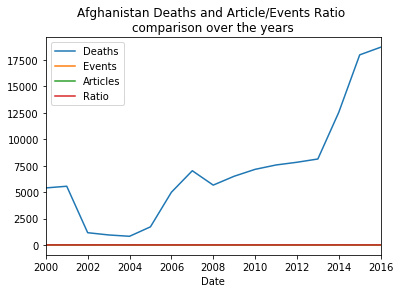

In [293]:
afg_year_normalized.plot(kind='line', title='Afghanistan Deaths and Article/Events Ratio \ncomparison over the years');

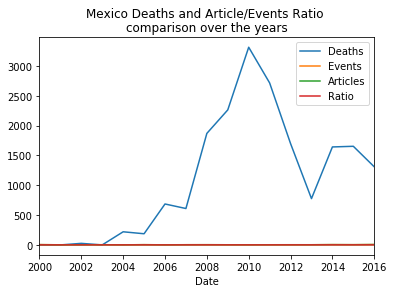

In [294]:
mex_year_normalized.plot(kind='line', title='Mexico Deaths and Article/Events Ratio \ncomparison over the years');

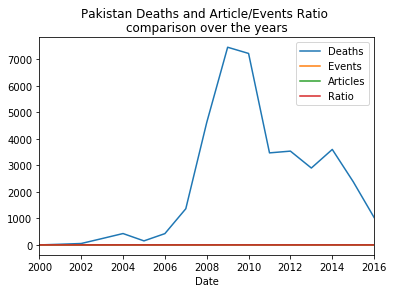

In [295]:
pak_year_normalized.plot(kind='line', title='Pakistan Deaths and Article/Events Ratio \ncomparison over the years');

There seem to indeed be some inconsistencies in the ratio between the number of deaths and the amount of media coverage per year as we planned, though not always exactly as we would have thought.

In [296]:
data  = [irq_year_normalized,afg_year_normalized,mex_year_normalized,pak_year_normalized]
data = pd.concat(data, axis=1)

data.columns = [x + '_' + y for y in ['Deaths', 'Events', 'Articles', 'Ratio'] for x in ['Iraq', 'Afghanistan', 'Mexico', 'Pakistan']]

data

,Iraq_Deaths,Afghanistan_Deaths,Mexico_Deaths,Pakistan_Deaths,Iraq_Events,Afghanistan_Events,Mexico_Events,Pakistan_Events,Iraq_Articles,Afghanistan_Articles,Mexico_Articles,Pakistan_Articles,Iraq_Ratio,Afghanistan_Ratio,Mexico_Ratio,Pakistan_Ratio
Date,,,,,,,,,,,,,,,,
2000,185,3.159566,2.827667,0.894954,5394,4.242186,3.764931,0.887498,0,5.154469,4.508636,0.874704,1,4.749720,4.614945,0.971625
2001,27,2.716475,2.373155,0.873615,5553,4.401630,3.700348,0.840677,0,2.046160,1.821338,0.890125,26,2.827711,2.601713,0.920077
2002,111,2.519822,2.051480,0.814137,1157,3.180485,2.993471,0.941200,26,2.627359,2.286448,0.870246,54,2.142570,2.107601,0.983679
2003,7999,3.116896,2.731123,0.876232,944,4.875105,4.743734,0.973053,0,3.330892,3.038819,0.912314,241,2.091984,1.850691,0.884659
2004,4365,3.156413,2.964102,0.939073,817,3.324882,2.800540,0.842298,220,1.543282,1.334053,0.864426,430,2.868041,2.961094,1.032445
2005,3521,4.152762,4.435722,1.068138,1711,2.978541,2.693523,0.904310,187,4.164987,3.821229,0.917465,153,4.053329,3.810348,0.940054
2006,4609,2.947239,2.473825,0.839370,4982,2.575510,2.202969,0.855352,686,1.668047,1.156241,0.693171,427,2.671083,2.501936,0.936675
2007,4489,4.328332,4.179108,0.965524,7020,2.261432,2.241169,0.991039,610,3.515364,2.898550,0.824538,1366,2.683201,2.394941,0.892569
2008,2732,3.112853,2.881639,0.925723,5660,2.033517,1.842517,0.906074,1869,3.568041,3.507732,0.983098,4620,1.900609,2.070814,1.089553


## Analysis by Event Code

In [297]:
df.head()

,Country,Date,EventCode,Events,Articles
0,SY,201609,19,0.004158,0.005237
1,SY,201608,19,0.003789,0.004822
2,SY,201602,19,0.004389,0.004538
3,SY,201510,19,0.003578,0.004398
4,SY,201612,19,0.003825,0.004289


In [298]:
def df_env_year(_df, country_code):
    x = _df[_df['Country'] == country_code].drop('Country', axis=1)
    x['Date'] = x['Date'].apply(lambda d: int(d / 100))
    return x.groupby(['Date', 'EventCode']).mean()

df_env = df.copy()

df_env['Ratio'] = df_env['Articles'] / df_env['Events'].astype('float')

df_env.drop(['Articles', 'Events'], axis=1, inplace=True)

irq_ev = df_env_year(df_env, 'IZ')
mex_ev = df_env_year(df_env, 'MX')
afg_ev = df_env_year(df_env, 'AF')
pak_ev = df_env_year(df_env, 'PK')
syr_ev = df_env_year(df_env, 'SY')

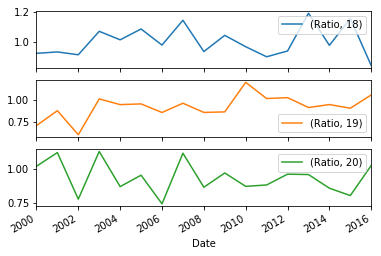

In [299]:
irq_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='line', subplots=True);

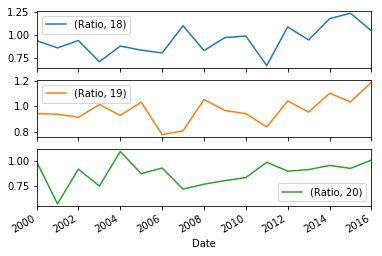

In [300]:
mex_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='line', subplots=True);

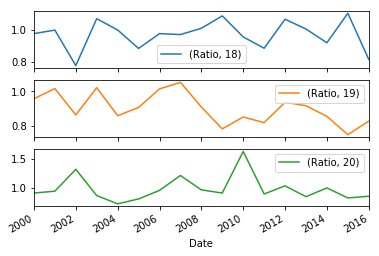

In [301]:
afg_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='line', subplots=True);

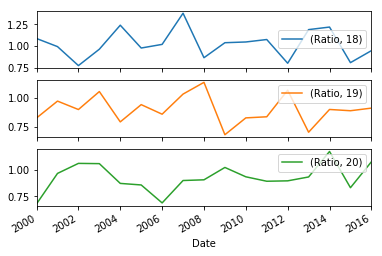

In [302]:
pak_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='line', subplots=True);

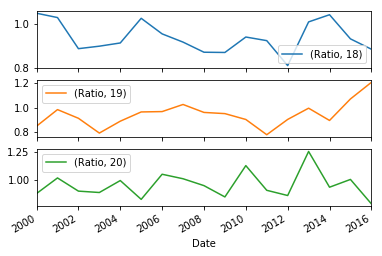

In [303]:
syr_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='line', subplots=True);

As we can see, the type of the events (18, 19 or 20) seems not to influence too much the final ratio between the number of events (i.e. each event has a relatively similar curve shape). This means that our choice of events is sound and can be used without worrying too much about event importance.

In [304]:
te = pd.read_csv("top_event_2000_2016.csv")
ta = pd.read_csv("top_acticles_2000_2016.csv")
te.set_index("ActionGeo_CountryCode").head(10)

,Sum_Events
ActionGeo_CountryCode,
US,9495320
IS,1388619
PK,1388042
IZ,1244830
AF,1176532
SY,1153458
UK,1054506
IN,1012818
RS,777605


In [305]:
ta.set_index("ActionGeo_CountryCode").head(10)

,Sum_Articles
ActionGeo_CountryCode,
US,126189062
SY,18233243
IS,16038607
IZ,15565613
AF,14920597
PK,14025192
UK,9708506
IN,8898081
AS,8213297


# Discussion

First, we know from our different queries that the number of article has greatly increase during the period of time we considered, namely 2000 to 2016. The number of sources that were scrap for each event has also changed over time. Therefore we will have to be careful to not interpret the number articles evolution in itself without care as a media coverage mesure.
The Syrian death reports seems to be temporary not available on the UDCP platform. 
Another important thing is that the articles sources seems to be mainly centered on american news platforms. This can be seen in the last two plots. The total number of event and articles for the US is huge. Therefore events in the US are more documented than other countries. That is why we think that US news are more investigated.
